Curso ministrado por Guilherme Silveira

** Machine Learning:** *Otimização de Parâmetros - Parte 01*

## Hiperparâmetros, *overfit* e otimização

### Primeira Parte

A primeira parte é revisão do curso *Validação de Modelos*, mas com a plotagem da árvore de decisão que foi realizada....

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [8]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [10]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

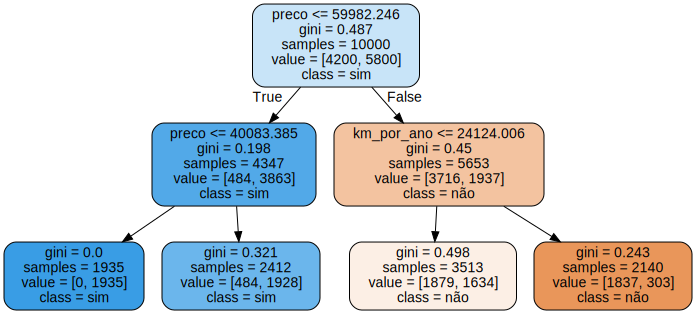

In [11]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

In [12]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


### Quanto mais complexa a árvore, melhor ela será???

#### Explorando Hiperparâmetros em Uma Dimensão

In [22]:
def roda_arvore_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    tabela = [max_depth, results['train_score'].mean()*100, results['test_score'].mean()*100]
    return tabela

resultados = [roda_arvore_decisao(i) for i in range (1, 33)]

dados_arvore = pd.DataFrame(resultados, columns=['max_depth', 'train_score', 'test_score'])

dados_arvore.head()

,max_depth,train_score,test_score
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


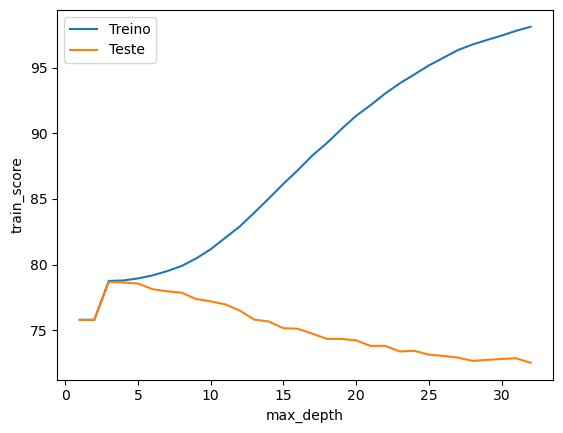

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data = dados_arvore, x = 'max_depth', y = 'train_score')
sns.lineplot(data = dados_arvore, x = 'max_depth', y = 'test_score')
plt.legend(['Treino', 'Teste'])


In [30]:
dados_arvore.sort_values('test_score', ascending=False).head()

,max_depth,train_score,test_score
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


A árvore está ficando cada vez melhor para os dados de treino, mas não está sendo eficiente para os dados de testes... <p>
Esse problema é denominado *overfitting*.

## Explorando 2 Dimensões de Hiperparâmetros

#### Explorando Hiperparâmetros em Uma Dimensão

In [36]:
def roda_arvore_decisao_2d(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    tabela = [max_depth, min_samples_leaf, results['train_score'].mean()*100, results['test_score'].mean()*100]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in range (1, 33):
            tabela = roda_arvore_decisao_2d(max_depth, min_samples_leaf)
            resultados.append(tabela)
    dados_arvore = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
    return dados_arvore

dados_arvore = busca()
dados_arvore.sort_values('test_score', ascending=False).head()

,max_depth,min_samples_leaf,train_score,test_score
0,1,1,75.791169,75.784219
1,1,2,75.791169,75.784219
2,1,3,75.791169,75.784219
3,1,4,75.791169,75.784219
4,1,5,75.791169,75.784219


In [38]:
dados_arvore.sort_values('test_score', ascending=False).head()

,max_depth,min_samples_leaf,train_score,test_score
123,4,28,78.750993,78.672633
126,4,31,78.750993,78.672633
85,3,22,78.750993,78.672633
84,3,21,78.750993,78.672633
83,3,20,78.750993,78.672633


In [42]:
corr = dados_arvore.corr()
corr

,max_depth,min_samples_leaf,train_score,test_score
max_depth,1.000000e+00,-3.757177e-16,0.681408,-0.522835
min_samples_leaf,-3.757177e-16,1.000000e+00,-0.453825,0.528330
train_score,6.814075e-01,-4.538248e-01,1.000000,-0.762534
test_score,-5.228349e-01,5.283299e-01,-0.762534,1.000000


<AxesSubplot:>

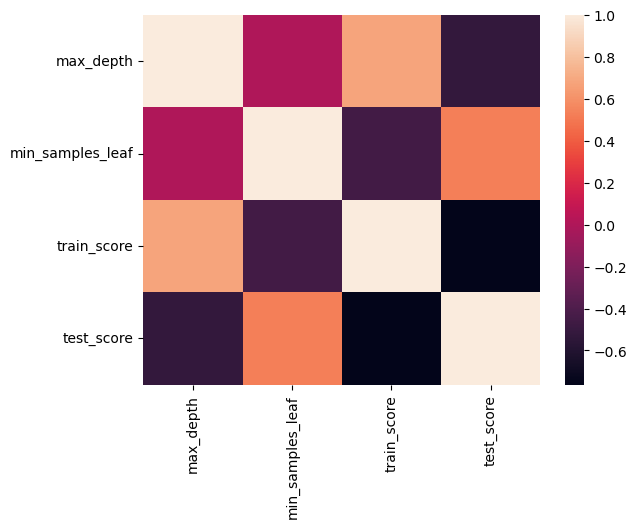

In [41]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train_score', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test_score', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train_score', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test_score', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train_score'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train_score'>,
        <AxesSubplot:xlabel='train_score', ylabel='train_score'>,
        <AxesSubplot:xlabel='test_score', ylabel='train_score'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test_score'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test_score'>,
        <AxesSubplot:xlabel='train_score', ylabel='tes

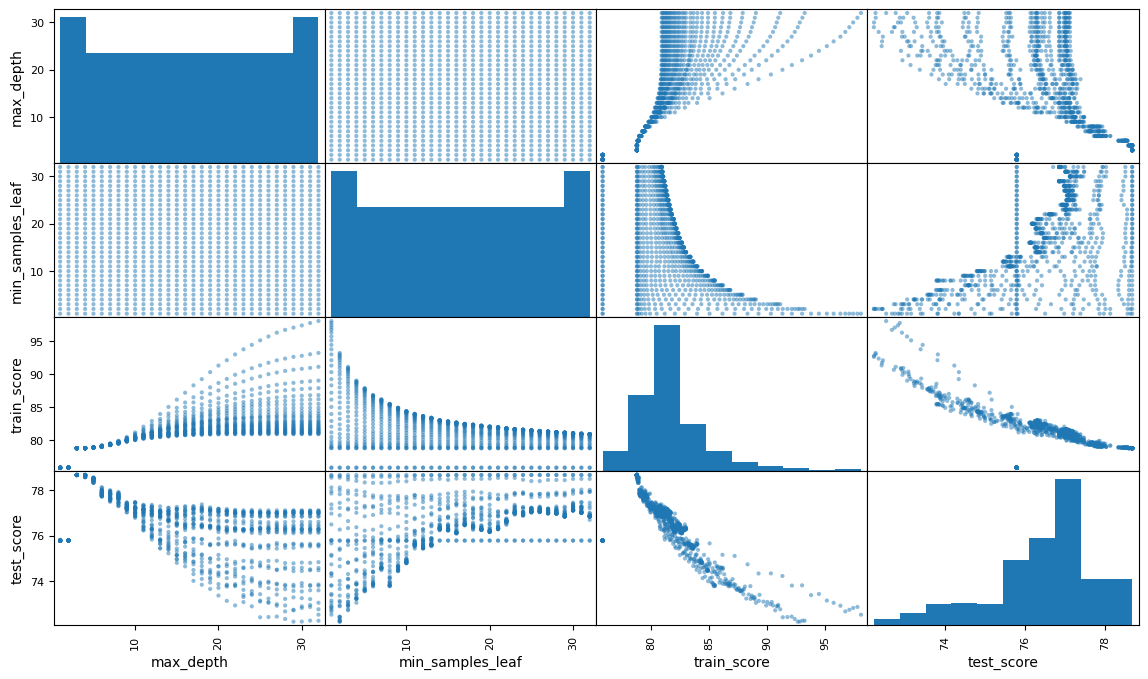

In [45]:
pd.plotting.scatter_matrix(dados_arvore, figsize = (14,8))

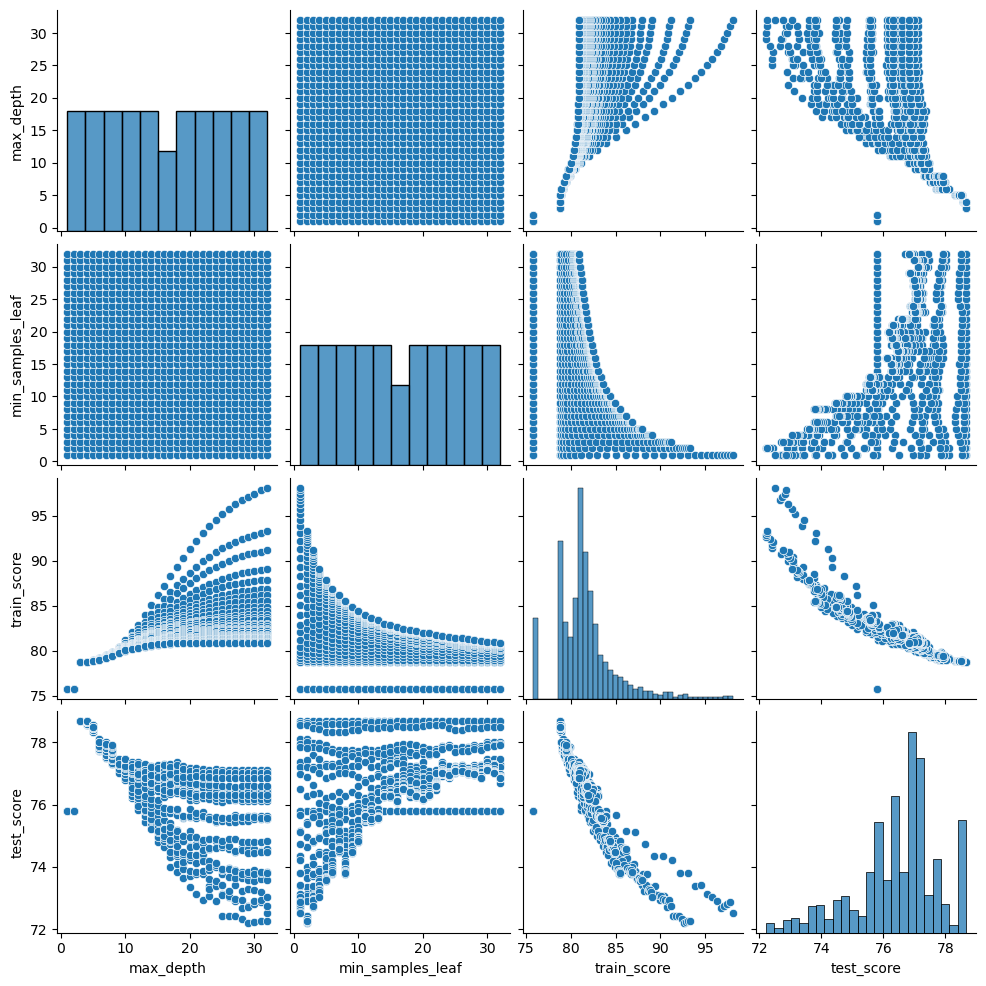

In [46]:
sns.pairplot(dados_arvore)

/tmp/ipykernel_16030/3792064364.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

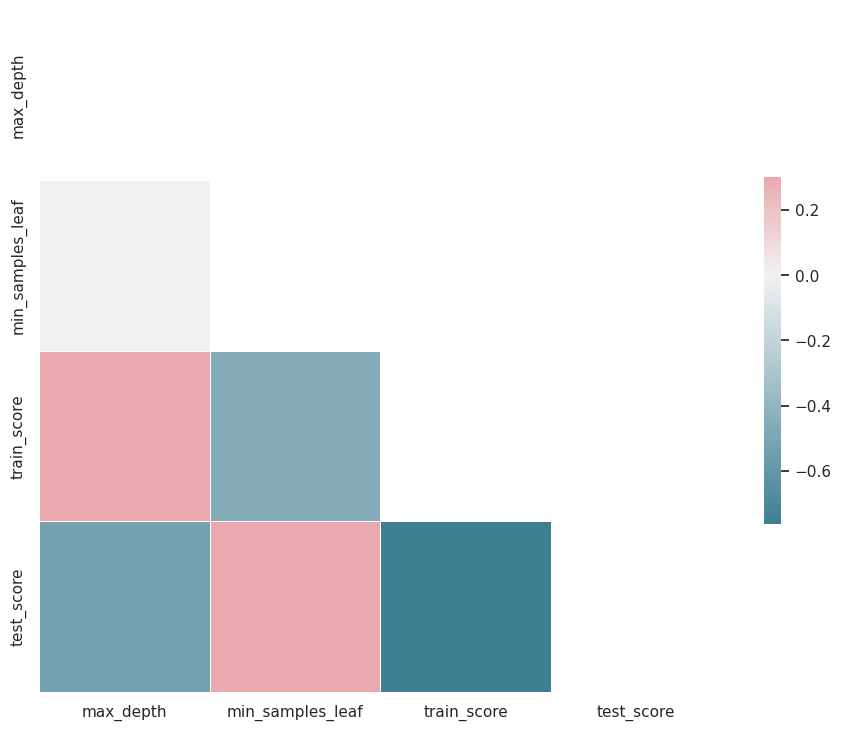

In [47]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [49]:
def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela = roda_arvore_decisao_2d(max_depth, min_samples_leaf)
            resultados.append(tabela)
    dados_arvore = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train_score', 'test_score'])
    return dados_arvore

dados_arvore = busca()
dados_arvore.sort_values('test_score', ascending=False).head()

,max_depth,min_samples_leaf,train_score,test_score
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


/tmp/ipykernel_16030/106543121.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

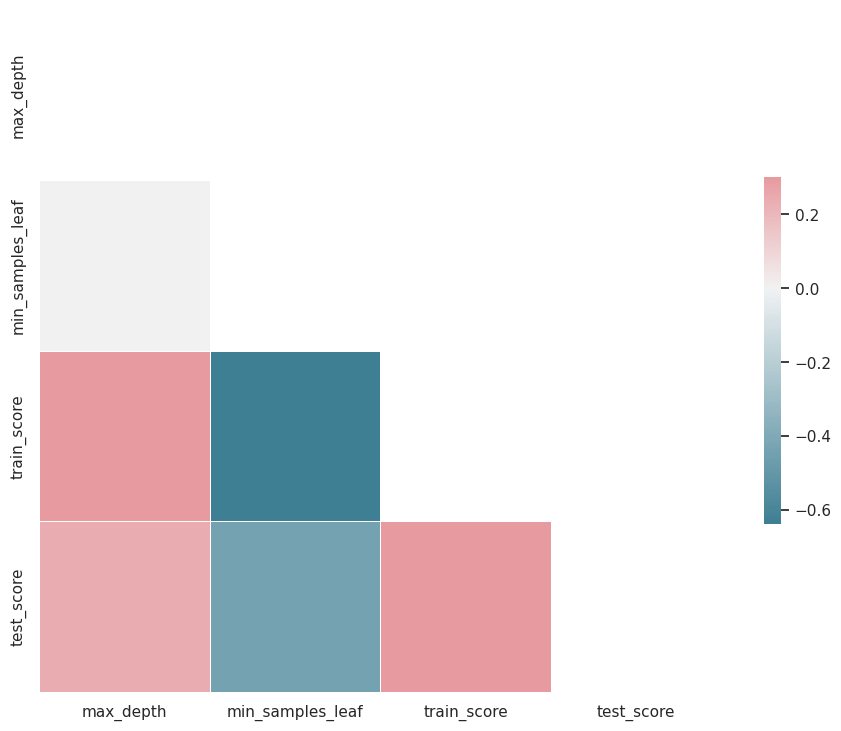

In [50]:
corr = dados_arvore.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Explorando 3 ou mais Dimensões

In [52]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test"])
  return resultados

resultados = busca()
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test
63,4,256,256,78.750993,78.672633
48,4,32,32,78.750993,78.672633
34,3,32,128,78.750993,78.672633
35,3,32,256,78.750993,78.672633
36,3,64,32,78.750993,78.672633


/tmp/ipykernel_16030/1815004217.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

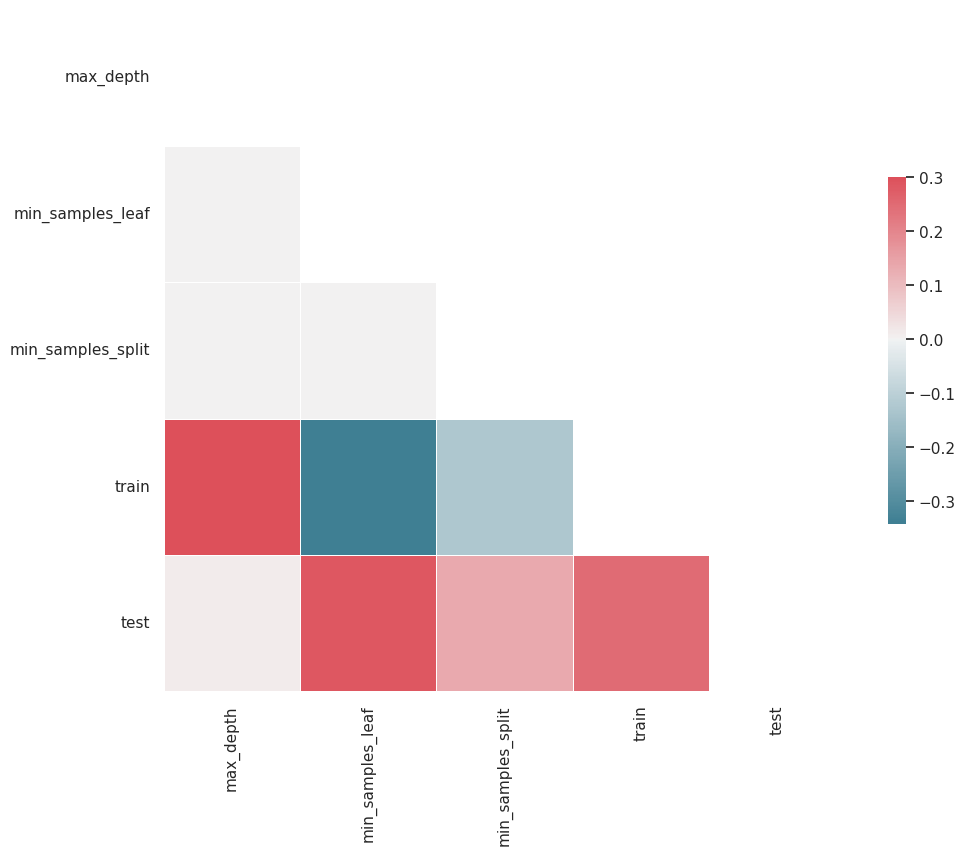

In [53]:
corr = resultados.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### GridSearchCV

In [54]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_parametreos = {
    'max_depth' : [3,5],
    'min_samples_split' : [32, 64, 128],
    'min_samples_leaf' : [32, 64, 128],
    'criterion' : ['gini', 'entropy']
}


busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_parametreos,
                     cv = GroupKFold(n_splits=10)
                     )

busca.fit(x_azar, y_azar, groups = dados['modelo'])
resultados = pd.DataFrame(busca.cv_results_)

resultados.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008407,0.001343,0.001467,0.000281,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.007981,0.000755,0.001571,0.000240,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.007550,0.000672,0.001302,0.000143,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007457,0.000395,0.001285,0.000149,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.007400,0.000557,0.001248,0.000118,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [57]:
resultados.shape

(36, 22)

In [60]:
print(busca.best_params_)
print(busca.best_score_ * 100)
print(busca.best_estimator_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332
DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


In [62]:
melhor = busca.best_estimator_

In [63]:
from sklearn.metrics import accuracy_score 

predicoes = melhor.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


A utilização do *predict* é uma abordagem otimista, pois os dados ficam viciados nos dados que já foram vistos.... Essa análise precisaria ser evitada.

### Estimativa sem Vício dos Dados

In [64]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados['modelo'])

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 874, in fit
    self._run_search(evaluate_candidates)
  File "/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 833, in evaluate_candidates
    for (cand_idx, parameters), (split_idx, (train, test)) in product(
  File "/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py", line 352, in split
    for train, test in super().split(X, y, groups):
  File "/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py", line 85, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py", line 97, in _iter_test_masks
    for test_index in self._iter_test_indices(X, y, groups):
  File "/home/sarah/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py", line 530, in _iter_test_indices
    raise ValueError("The 'groups' parameter should not be None.")
ValueError: The 'groups' parameter should not be None.


Problema: essa análise apresenta um *bug* que está em aberto desde 2016.... <p>
Alternativa: Utilizar o KFold tradicional, e não o GroupKFold

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

espaco_parametreos = {
    'max_depth' : [3,5],
    'min_samples_split' : [32, 64, 128],
    'min_samples_leaf' : [32, 64, 128],
    'criterion' : ['gini', 'entropy']
}


busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_parametreos,
                     cv = KFold(n_splits=5, shuffle = True)
                     )

busca.fit(x_azar, y_azar, groups = dados['modelo'])
resultados = pd.DataFrame(busca.cv_results_)

resultados.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007101,0.000553,0.001462,0.000266,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.006739,0.000302,0.001468,0.000101,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.007387,0.000259,0.001690,0.000617,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.006768,0.000521,0.001372,0.000077,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.006918,0.000459,0.001348,0.000094,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [67]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [70]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio: %.2f" % media)
  print("Intervalo: [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [71]:
imprime_score(scores)

Accuracy médio: 78.67
Intervalo: [76.80, 80.54]


In [72]:
print(busca.best_estimator_)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)
